In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.options.mode.chained_assignment = None

stock_data = pd.read_csv('df2330_12to22.csv')

stock_data['trend'] = np.where(stock_data.Close.shift(-5) > stock_data.Close, 1, 0)
print(stock_data.isnull().sum())

print(stock_data)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
trend     0
dtype: int64
            Date   Open   High    Low  Close     Volume  trend
0       2012/1/2   75.0   75.4   74.7   75.0  14945.219      1
1       2012/1/3   75.5   75.9   75.2   75.7  21223.640      1
2       2012/1/4   76.1   76.1   75.5   75.8  34126.472      1
3       2012/1/5   76.0   76.0   75.3   76.0  28076.670      1
4       2012/1/6   75.9   75.9   74.9   75.6  30123.118      1
...          ...    ...    ...    ...    ...        ...    ...
2697  2022/12/26  454.0  457.0  453.5  456.5   9152.790      0
2698  2022/12/27  458.0  462.5  457.0  457.0  10486.219      0
2699  2022/12/28  451.0  452.0  446.0  451.0  34823.492      0
2700  2022/12/29  444.0  449.5  442.5  446.0  25596.357      0
2701  2022/12/30  455.0  456.5  448.5  448.5  22297.604      0

[2702 rows x 7 columns]


In [2]:
# define the target and features
target = ['Close']
features = ['Volume', 'High', 'Low','trend']

In [3]:
df = stock_data[features + target]
df

,Volume,High,Low,trend,Close
0,14945.219,75.4,74.7,1,75.0
1,21223.640,75.9,75.2,1,75.7
2,34126.472,76.1,75.5,1,75.8
3,28076.670,76.0,75.3,1,76.0
4,30123.118,75.9,74.9,1,75.6
...,...,...,...,...,...
2697,9152.790,457.0,453.5,0,456.5
2698,10486.219,462.5,457.0,0,457.0
2699,34823.492,452.0,446.0,0,451.0
2700,25596.357,449.5,442.5,0,446.0


In [4]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

In [5]:
df_train

,Volume,High,Low,trend,Close
0,14945.219,75.4,74.7,1,75.0
1,21223.640,75.9,75.2,1,75.7
2,34126.472,76.1,75.5,1,75.8
3,28076.670,76.0,75.3,1,76.0
4,30123.118,75.9,74.9,1,75.6
...,...,...,...,...,...
2156,49987.278,456.5,450.0,1,453.0
2157,48274.801,456.0,448.5,1,449.0
2158,34846.906,457.5,451.0,0,457.5
2159,26567.638,457.0,451.0,0,451.0


In [6]:
df_test

,Volume,High,Low,trend,Close
2161,25285.547,455.0,449.5,0,455.0
2162,18777.385,458.0,451.5,0,452.0
2163,15800.622,455.0,450.0,0,450.0
2164,31795.010,448.5,445.5,0,447.0
2165,26221.663,447.0,443.0,1,444.0
...,...,...,...,...,...
2697,9152.790,457.0,453.5,0,456.5
2698,10486.219,462.5,457.0,0,457.0
2699,34823.492,452.0,446.0,0,451.0
2700,25596.357,449.5,442.5,0,446.0


In [7]:
# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])


In [8]:
df_train

,Volume,High,Low,trend,Close
0,0.078594,0.001532,0.002346,1.0,0.001806
1,0.115392,0.002808,0.003649,1.0,0.003611
2,0.191014,0.003319,0.004431,1.0,0.003869
3,0.155556,0.003064,0.003909,1.0,0.004385
4,0.167551,0.002808,0.002867,1.0,0.003353
...,...,...,...,...,...
2156,0.283972,0.974470,0.980453,1.0,0.976786
2157,0.273936,0.973194,0.976544,1.0,0.966469
2158,0.195236,0.977023,0.983060,0.0,0.988393
2159,0.146712,0.975747,0.983060,0.0,0.971628


In [9]:
# extract the input sequences and output values
sequence_length = 10

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape)

print(X_test.shape)

(2151, 10, 5)
(531, 10, 5)


In [10]:
X_train

array([[[0.07859449, 0.00153178, 0.00234558, 1.        , 0.00180552],
        [0.11539163, 0.00280827, 0.00364868, 1.        , 0.00361104],
        [0.19101372, 0.00331887, 0.00443054, 1.        , 0.00386897],
        ...,
        [0.25061206, 0.00561654, 0.00599427, 1.        , 0.00567449],
        [0.31640247, 0.00587184, 0.00703675, 1.        , 0.00696415],
        [0.32951383, 0.00816952, 0.00833985, 1.        , 0.0082538 ]],

       [[0.11539163, 0.00280827, 0.00364868, 1.        , 0.00361104],
        [0.19101372, 0.00331887, 0.00443054, 1.        , 0.00386897],
        [0.15555649, 0.00306357, 0.0039093 , 1.        , 0.00438483],
        ...,
        [0.31640247, 0.00587184, 0.00703675, 1.        , 0.00696415],
        [0.32951383, 0.00816952, 0.00833985, 1.        , 0.0082538 ],
        [0.2120244 , 0.00536125, 0.00208496, 1.        , 0.00257931]],

       [[0.19101372, 0.00331887, 0.00443054, 1.        , 0.00386897],
        [0.15555649, 0.00306357, 0.0039093 , 1.        , 0.0

In [11]:
X_test

array([[[0.13919802, 0.9706408 , 0.97915038, 0.        , 0.9819448 ],
        [0.10105439, 0.97829972, 0.98436278, 0.        , 0.97420686],
        [0.08360791, 0.9706408 , 0.98045348, 0.        , 0.96904823],
        ...,
        [0.19343488, 0.9208578 , 0.92311702, 1.        , 0.93164818],
        [0.17539594, 0.94000511, 0.94917905, 1.        , 0.94583441],
        [0.21330375, 0.96170539, 0.96221006, 1.        , 0.96904823]],

       [[0.10105439, 0.97829972, 0.98436278, 0.        , 0.97420686],
        [0.08360791, 0.9706408 , 0.98045348, 0.        , 0.96904823],
        [0.17734928, 0.95404646, 0.96872557, 0.        , 0.96131029],
        ...,
        [0.17539594, 0.94000511, 0.94917905, 1.        , 0.94583441],
        [0.21330375, 0.96170539, 0.96221006, 1.        , 0.96904823],
        [0.2051559 , 0.96170539, 0.96872557, 1.        , 0.97162755]],

       [[0.08360791, 0.9706408 , 0.98045348, 0.        , 0.96904823],
        [0.17734928, 0.95404646, 0.96872557, 0.        , 0.9

In [12]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
model.add(Dense(units=100))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           60400     
                                                                 
 dropout_1 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 200)               240800    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               2

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
model.save('multi_intput_LSTM_model_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
34/34 [==============================] - 5s 43ms/step - loss: 0.0101
Epoch 2/50
34/34 [==============================] - 2s 59ms/step - loss: 0.0012
Epoch 3/50
34/34 [==============================] - 2s 49ms/step - loss: 8.5490e-04
Epoch 4/50
34/34 [==============================] - 2s 46ms/step - loss: 7.7451e-04
Epoch 5/50
34/34 [==============================] - 1s 43ms/step - loss: 7.0014e-04
Epoch 6/50
34/34 [==============================] - 1s 41ms/step - loss: 5.6906e-04
Epoch 7/50
34/34 [==============================] - 1s 38ms/step - loss: 6.7944e-04
Epoch 8/50
34/34 [==============================] - 1s 41ms/step - loss: 5.0834e-04
Epoch 9/50
34/34 [==============================] - 1s 39ms/step - loss: 5.2826e-04
Epoch 10/50
34/34 [==============================] - 2s 47ms/step - loss: 5.0572e-04
Epoch 11/50
34/34 [==============================] - 2s 46ms/step - loss: 5.1143e-04
Epoch 12/50
34/34 [==============================] - 1s 42ms/step - loss: 5.6055e-

In [14]:
y_pred.flatten()

array([456.60425, 461.59387, 466.30984, 471.     , 475.6711 , 477.16092,
       479.87015, 483.0815 , 486.98245, 491.19016, 494.62494, 496.73688,
       497.94052, 498.19662, 497.90164, 497.4202 , 497.6451 , 498.8675 ,
       500.94638, 503.29532, 510.00308, 516.21954, 519.2868 , 524.43646,
       527.0955 , 524.53894, 520.4494 , 515.45544, 512.9492 , 511.14194,
       509.98187, 510.1118 , 511.90665, 516.6925 , 520.3289 , 523.7435 ,
       527.683  , 531.362  , 531.6757 , 533.29736, 538.75055, 540.758  ,
       543.951  , 550.6279 , 554.2994 , 559.3176 , 565.4642 , 572.41174,
       580.1823 , 588.6872 , 597.36475, 606.00684, 613.9653 , 620.3657 ,
       624.63336, 626.49774, 626.4505 , 624.8348 , 622.70795, 621.3157 ,
       622.5173 , 623.91394, 626.3043 , 632.50903, 637.92175, 641.3248 ,
       645.91144, 650.567  , 649.722  , 647.6963 , 645.66974, 642.2074 ,
       637.17993, 629.41907, 621.1975 , 613.3368 , 605.2796 , 602.5431 ,
       600.8461 , 601.45935, 603.11523, 607.00867, 

In [20]:
y_pred.shape[0]

531

In [15]:
# import matplotlib.pyplot as plt
# train_history.history
# plt.plot(train_history.history["loss"])
# # plt.plot(train_history.history["val_loss"])
# plt.title("Train History")
# plt.ylabel("loss")
# plt.xlabel("Epoch")
# plt.legend(['train','validation'],loc='upper left')
# # plt.show()

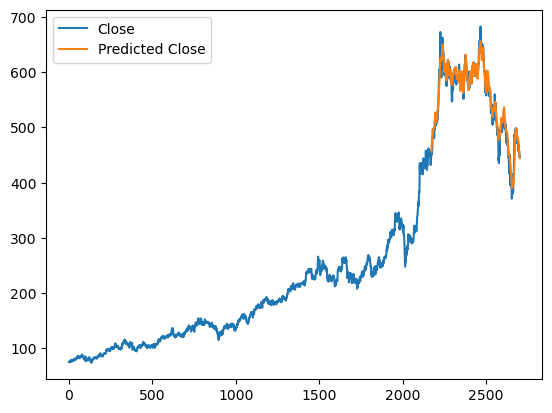

In [16]:
# plot the test set predictions
df['Predicted Close'] = np.nan
df['Predicted Close'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
plot=df[['Close', 'Predicted Close']].plot()
fig = plot.get_figure()
fig.savefig("multi_intput_LSTM_model_eps32_bsize64.png")

In [17]:
res=pd.concat([stock_data['Date'],df],axis=1)
res

,Date,Volume,High,Low,trend,Close,Predicted Close
0,2012/1/2,14945.219,75.4,74.7,1,75.0,NaN
1,2012/1/3,21223.640,75.9,75.2,1,75.7,NaN
2,2012/1/4,34126.472,76.1,75.5,1,75.8,NaN
3,2012/1/5,28076.670,76.0,75.3,1,76.0,NaN
4,2012/1/6,30123.118,75.9,74.9,1,75.6,NaN
...,...,...,...,...,...,...,...
2697,2022/12/26,9152.790,457.0,453.5,0,456.5,453.249603
2698,2022/12/27,10486.219,462.5,457.0,0,457.0,451.114960
2699,2022/12/28,34823.492,452.0,446.0,0,451.0,449.312744
2700,2022/12/29,25596.357,449.5,442.5,0,446.0,447.012177


In [18]:
dfpred=res[['Date','Close', 'Predicted Close']].dropna()
dfpred

,Date,Close,Predicted Close
2171,2020/11/5,451.0,456.604248
2172,2020/11/6,452.5,461.593872
2173,2020/11/9,458.5,466.309845
2174,2020/11/10,451.0,471.000000
2175,2020/11/11,457.0,475.671112
...,...,...,...
2697,2022/12/26,456.5,453.249603
2698,2022/12/27,457.0,451.114960
2699,2022/12/28,451.0,449.312744
2700,2022/12/29,446.0,447.012177


<AxesSubplot: xlabel='Date'>

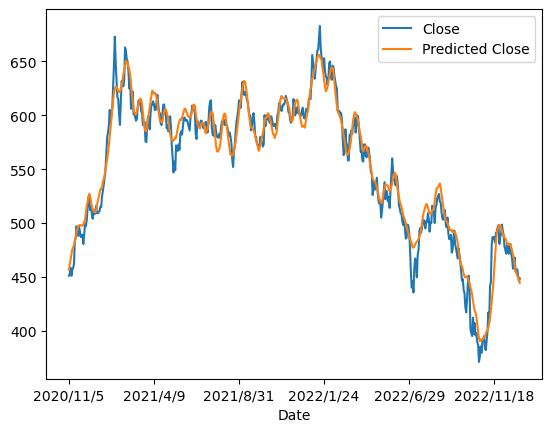

In [19]:
dfpred.plot(x='Date')